In [ ]:
import requests
import os
import json

# Azure Custom Vision API 설정
subscription_key = "3k6ZUYvFucX17CmlJxfqWFrTwzzdwpIcfP9GmRZBgwXpaM366UjZJQQJ99BBACYeBjFXJ3w3AAAJACOGKHD2"  # 예: "YOUR-API-KEY"
prediction_key = "6SAcESgHgaKkf9BjA7UA9jQE5eZnuEkF79k0utnYIj4Nj8zGwgjJJQQJ99BBACYeBjFXJ3w3AAAIACOGCII7"  # 예: "YOUR-PREDICTION-KEY"
endpoint = "https://6a044cv20250210-prediction.cognitiveservices.azure.com"  # 예: "https://<your-region>.api.cognitive.microsoft.com"
project_id = "4c0f712d-9091-4b85-a828-0b4378407ff0"  # 예: "your-project-id"
iteration_id = "Iteration2"  # 예: "your-iteration-id"

# API URL 설정
prediction_url = "https://6a044cv20250210-prediction.cognitiveservices.azure.com/customvision/v3.0/Prediction/4c0f712d-9091-4b85-a828-0b4378407ff0/detect/iterations/Iteration2/url"

# 이미지를 가져올 폴더 설정
image_folder = "data/blackbox_ss"  # 이미지 폴더 경로
output_folder = "git/License-Plate-Identification\cropped box"  # 예측된 결과를 저장할 폴더

# 이미지 파일을 순차적으로 가져오기
def get_image_files(image_folder):
    return [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# 이미지를 API로 예측 요청하기
def predict_image(image_path):
    with open(image_path, "rb") as image_file:
        image_data = image_file.read()

    headers = {
        "Content-Type": "application/octet-stream",
        "Prediction-Key": prediction_key
    }

    response = requests.post(prediction_url, headers=headers, data=image_data)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None

# 바운딩 박스를 수정하는 로직
def modify_bounding_boxes(prediction):
    # 예: 예측 결과에서 잘못된 바운딩 박스를 수정하는 로직
    modified_predictions = []
    for prediction_item in prediction.get("predictions", []):
        if prediction_item["tagName"] == "Car" and prediction_item["probability"] > 0.7:
            # 여기에서 예측된 태그와 바운딩 박스를 수정 가능
            # 예를 들어, 특정 조건을 만족하면 바운딩 박스를 변경하거나 추가 정보를 반영
            prediction_item["boundingBox"]["left"] += 0.05  # 예시: 왼쪽 여백 늘리기
            prediction_item["boundingBox"]["top"] -= 0.05  # 예시: 위쪽 여백 줄이기
            modified_predictions.append(prediction_item)
    return modified_predictions

# 결과를 출력하거나 저장하기
def save_predictions(image_name, modified_predictions):
    output_path = os.path.join(output_folder, f"{image_name}_predictions.json")
    with open(output_path, "w") as output_file:
        json.dump(modified_predictions, output_file, indent=4)
    print(f"Predictions saved to {output_path}")

# 메인 처리 함수
def process_images(image_folder):
    image_files = get_image_files(image_folder)
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        print(f"Processing {image_file}...")

        # 1. 예측 받기
        prediction = predict_image(image_path)

        if prediction:
            # 2. 바운딩 박스 수정하기
            modified_predictions = modify_bounding_boxes(prediction)
            
            # 3. 결과 저장하기
            save_predictions(image_file, modified_predictions)

# 이미지 처리 실행
process_images(image_folder)


In [ ]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Azure Custom Vision 정보
ENDPOINT = "https://6a044cv20250210-prediction.cognitiveservices.azure.com"  # 수정요망#
PREDICTION_KEY = "6SAcESgHgaKkf9BjA7UA9jQE5eZnuEkF79k0utnYIj4Nj8zGwgjJJQQJ99BBACYeBjFXJ3w3AAAIACOGCII7"  # 수정요망#
PROJECT_ID = "4c0f712d-9091-4b85-a828-0b4378407ff0"  # 수정요망#
PUBLISHED_MODEL_NAME = "Iteration2"  # 학습된 모델의 이름, 수정요망#

# ApiKeyCredentials 객체 생성
credentials = ApiKeyCredentials(in_headers={"Prediction-key": PREDICTION_KEY})

# Custom Vision Prediction 클라이언트 생성
predictor = CustomVisionPredictionClient(endpoint=ENDPOINT, credentials=credentials)

# 이미지 파일이 있는 폴더 경로
folder_path = r"data\blackbox_ss"  # 수정요망#

# 폴더 내 모든 이미지 파일에 대해 예측 수행
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # 필요한 확장자 추가 가능
        image_path = os.path.join(folder_path, filename)
        with open(image_path, "rb") as image_data:
            # 모델을 사용하여 이미지에서 번호판 위치 예측
            results = predictor.detect_image(PROJECT_ID, PUBLISHED_MODEL_NAME, image_data)

            # 이미지 로드
            image = Image.open(image_path)
            fig, ax = plt.subplots(1, figsize=(8, 6))
            ax.imshow(image)

            # 바운딩 박스 그리기
            for prediction in results.predictions:
                if prediction.probability > 0.7:  # 신뢰도 70% 이상인 객체만 표시, 필요하면 조절 가능
                    left = prediction.bounding_box.left * image.width
                    top = prediction.bounding_box.top * image.height
                    width = prediction.bounding_box.width * image.width
                    height = prediction.bounding_box.height * image.height

                    # 바운딩 박스 추가
                    rect = patches.Rectangle((left, top), width, height, linewidth=2, edgecolor='red', facecolor='none')
                    ax.add_patch(rect)
                    
                    # 라벨 추가
                    ax.text(left, top - 5, f"{prediction.tag_name} ({prediction.probability:.2f})",
                            bbox=dict(facecolor='yellow', alpha=0.5), fontsize=10, color='black')

                    print(f"Tag: {prediction.tag_name}, Probability: {prediction.probability:.2f}")
                    print(f"Bounding Box - Left: {left:.2f}, Top: {top:.2f}, Width: {width:.2f}, Height: {height:.2f}")

            # 결과 이미지 출력
            plt.axis("off")
            plt.show()
q

# 바운딩 박스 모두 크롭하여 저장하기, 태그는 front, rear

In [ ]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Azure Custom Vision 정보
ENDPOINT = "https://6a044cv20250210-prediction.cognitiveservices.azure.com"  # 수정요망#
PREDICTION_KEY = "6SAcESgHgaKkf9BjA7UA9jQE5eZnuEkF79k0utnYIj4Nj8zGwgjJJQQJ99BBACYeBjFXJ3w3AAAIACOGCII7"  # 수정요망#
PROJECT_ID = "4c0f712d-9091-4b85-a828-0b4378407ff0"  # 수정요망#
PUBLISHED_MODEL_NAME = "Iteration2"  # 학습된 모델의 이름, 수정요망#

# API Key 설정
credentials = ApiKeyCredentials(in_headers={"Prediction-key": PREDICTION_KEY})

# Azure Custom Vision Prediction 클라이언트 생성
predictor = CustomVisionPredictionClient(ENDPOINT, credentials=credentials)

# 이미지가 저장된 폴더
folder_path = r"data\blackbox_ss"  # 분석할 이미지 폴더
output_folder = r"data\cropped_images"  # 크롭된 이미지 저장 폴더
os.makedirs(output_folder, exist_ok=True)  # 폴더가 없으면 생성

# 바운딩 박스 좌표를 저장할 파일
output_txt = os.path.join(output_folder, "detections.txt")

# 파일 열기 (덮어쓰기 모드)
with open(output_txt, "w") as f:
    f.write("Filename,Tag,Probability,Left,Top,Width,Height\n")  # 헤더 추가

    # 폴더 내 모든 이미지 처리
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)

            with open(image_path, "rb") as image_data:
                # Custom Vision 모델에 이미지 전송 및 예측
                results = predictor.detect_image(PROJECT_ID, PUBLISHED_MODEL_NAME, image_data)

            # 원본 이미지 로드
            image = Image.open(image_path)
            fig, ax = plt.subplots(1, figsize=(8, 6))
            ax.imshow(image)

            detected = False  # 감지 여부 체크

            # 바운딩 박스 처리
            # 바운딩 박스 처리
            # 바운딩 박스 처리
            for idx, prediction in enumerate(results.predictions):
                # 확신도 70% 이상인 경우만 크롭
                if prediction.probability > 0.7:  # 70% 이상인 예측만 크롭
                    # 바운딩 박스 좌표 변환 (비율 → 픽셀)
                    left = int(prediction.bounding_box.left * image.width)
                    top = int(prediction.bounding_box.top * image.height)
                    width = int(prediction.bounding_box.width * image.width)
                    height = int(prediction.bounding_box.height * image.height)

                    # 바운딩 박스 추가 (시각화용)
                    rect = patches.Rectangle((left, top), width, height, linewidth=2, edgecolor='red', facecolor='none')
                    ax.add_patch(rect)

                    # 텍스트 추가
                    ax.text(left, top - 5, f"{prediction.tag_name} ({prediction.probability:.2f})",
                            bbox=dict(facecolor='yellow', alpha=0.5), fontsize=10, color='black')

                    print(f"Tag: {prediction.tag_name}, Probability: {prediction.probability:.2f}")
                    print(f"Bounding Box - Left: {left}, Top: {top}, Width: {width}, Height: {height}")

                    # 감지된 객체 크롭
                    cropped_img = image.crop((left, top, left + width, top + height))
                    
                    # RGBA 모드인 경우 RGB로 변환
                    if cropped_img.mode == 'RGBA':
                        cropped_img = croqqpped_img.convert('RGB')

                    # 바운딩 박스 인덱스를 파일명에 추가하여 여러 개 저장 가능하게 함
                    cropped_img_path = os.path.join(output_folder, f"cropped_{filename}_{idx}.jpg")
                    cropped_img.save(cropped_img_path)

                    # 바운딩 박스 좌표 저장
                    f.write(f"{filename},{prediction.tag_name},{prediction.probability:.2f},{left},{top},{width},{height}\n")

                    detected = True  # 객체 감지됨



            if detected:
                plt.axis("off")
                plt.show()


인풋:폴더, 아웃풋:바운딩박스 크롭 이미지 모두

In [ ]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Azure Custom Vision 정보
ENDPOINT = "https://6a044cv20250210-prediction.cognitiveservices.azure.com"  # 수정요망#
PREDICTION_KEY = "6SAcESgHgaKkf9BjA7UA9jQE5eZnuEkF79k0utnYIj4Nj8zGwgjJJQQJ99BBACYeBjFXJ3w3AAAIACOGCII7"  # 수정요망#
PROJECT_ID = "4c0f712d-9091-4b85-a828-0b4378407ff0"  # 수정요망#
PUBLISHED_MODEL_NAME = "Iteration2"  # 학습된 모델의 이름, 수정요망#

# API Key 설정
credentials = ApiKeyCredentials(in_headers={"Prediction-key": PREDICTION_KEY})

# Azure Custom Vision Prediction 클라이언트 생성
predictor = CustomVisionPredictionClient(ENDPOINT, credentials=credentials)

# 이미지가 저장된 폴더
folder_path = r"data\blackbox_ss"  # 분석할 이미지 폴더
output_folder = r"data\cropped_images"  # 크롭된 이미지 저장 폴더
os.makedirs(output_folder, exist_ok=True)  # 폴더가 없으면 생성

# 바운딩 박스 좌표를 저장할 파일
output_txt = os.path.join(output_folder, "detections.txt")

# 파일 열기 (덮어쓰기 모드)
with open(output_txt, "w") as f:
    f.write("Filename,Tag,Probability,Left,Top,Width,Height\n")  # 헤더 추가

    # 폴더 내 모든 이미지 처리
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)

            with open(image_path, "rb") as image_data:
                # Custom Vision 모델에 이미지 전송 및 예측
                results = predictor.detect_image(PROJECT_ID, PUBLISHED_MODEL_NAME, image_data)

            # 원본 이미지 로드
            image = Image.open(image_path)
            fig, ax = plt.subplots(1, figsize=(8, 6))
            ax.imshow(image)

            detected = False  # 감지 여부 체크
            base_name, ext = os.path.splitext(filename)  # 파일명과 확장자 분리

            # 바운딩 박스 처리
            for idx, prediction in enumerate(results.predictions):
                # 확신도 70% 이상인 경우만 크롭
                if prediction.probability > 0.7:
                    # 태그를 "car"로 통합
                    prediction.tag_name = "car"

                    # 바운딩 박스 좌표 변환 (비율 → 픽셀)
                    left = int(prediction.bounding_box.left * image.width)
                    top = int(prediction.bounding_box.top * image.height)
                    width = int(prediction.bounding_box.width * image.width)
                    height = int(prediction.bounding_box.height * image.height)

                    # 바운딩 박스 추가 (시각화용)
                    rect = patches.Rectangle((left, top), width, height, linewidth=2, edgecolor='red', facecolor='none')
                    ax.add_patch(rect)

                    # 텍스트 추가
                    ax.text(left, top - 5, f"{prediction.tag_name} ({prediction.probability:.2f})",
                            bbox=dict(facecolor='yellow', alpha=0.5), fontsize=10, color='black')

                    print(f"Tag: {prediction.tag_name}, Probability: {prediction.probability:.2f}")
                    print(f"Bounding Box - Left: {left}, Top: {top}, Width: {width}, Height: {height}")

                    # 감지된 객체 크롭
                    cropped_img = image.crop((left, top, left + width, top + height))
                    
                    # RGBA 모드인 경우 RGB로 변환
                    if cropped_img.mode in ['RGBA', 'P']:  
                        cropped_img = cropped_img.convert('RGB')

                    # 바운딩 박스 인덱스를 파일명에 추가하여 저장
                    cropped_img_path = os.path.join(output_folder, f"{base_name}_cropped_{idx}{ext}")
                    cropped_img.save(cropped_img_path)

                    # 바운딩 박스 좌표 저장 (모든 태그를 "car"로 기록)
                    f.write(f"{filename},car,{prediction.probability:.2f},{left},{top},{width},{height}\n")

                    detected = True  # 객체 감지됨

            if detected:
                plt.axis("off")
                plt.show()


인풋:파일

Tag: car, Probability: 1.00
Bounding Box - Left: 1183, Top: 5, Width: 105, Height: 74
Tag: car, Probability: 1.00
Bounding Box - Left: 254, Top: 789, Width: 651, Height: 281
Tag: car, Probability: 1.00
Bounding Box - Left: 1339, Top: 156, Width: 126, Height: 110
Tag: car, Probability: 0.99
Bounding Box - Left: 1678, Top: 278, Width: 241, Height: 353
Tag: car, Probability: 0.95
Bounding Box - Left: 1681, Top: 177, Width: 238, Height: 711
Tag: car, Probability: 0.89
Bounding Box - Left: 1519, Top: 138, Width: 33, Height: 47
Tag: car, Probability: 0.77
Bounding Box - Left: 1627, Top: 483, Width: 292, Height: 422
Tag: car, Probability: 1.00
Bounding Box - Left: 1243, Top: 78, Width: 68, Height: 48
Tag: car, Probability: 0.99
Bounding Box - Left: 829, Top: 319, Width: 189, Height: 308
Tag: car, Probability: 0.98
Bounding Box - Left: 1106, Top: 537, Width: 273, Height: 459
Tag: car, Probability: 0.97
Bounding Box - Left: 1136, Top: 30, Width: 41, Height: 38
Tag: car, Probability: 0.96
Boundi

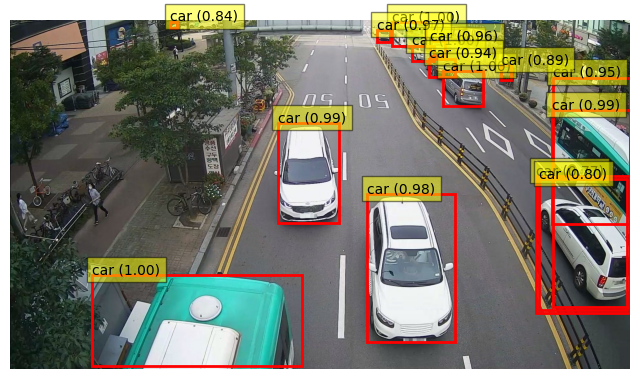

In [ ]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Azure Custom Vision 정보
ENDPOINT = "https://6a044cv20250210-prediction.cognitiveservices.azure.com"  # 수정요망#
PREDICTION_KEY = "6SAcESgHgaKkf9BjA7UA9jQE5eZnuEkF79k0utnYIj4Nj8zGwgjJJQQJ99BBACYeBjFXJ3w3AAAIACOGCII7"  # 수정요망#
PROJECT_ID = "41cd72bd-f812-488c-b4e6-4c515f664b75"  # 수정요망#
PUBLISHED_MODEL_NAME = "Iteration1"  # 학습된 모델의 이름, 수정요망#

# API Key 설정
credentials = ApiKeyCredentials(in_headers={"Prediction-key": PREDICTION_KEY})

# Azure Custom Vision Prediction 클라이언트 생성
predictor = CustomVisionPredictionClient(ENDPOINT, credentials=credentials)

# 크롭된 이미지 저장 폴더
output_folder = r"data\cropped_images"  # 크롭된 이미지 저장 폴더
os.makedirs(output_folder, exist_ok=True)  # 폴더가 없으면 생성

# 바운딩 박스 좌표를 저장할 파일
output_txt = os.path.join(output_folder, "detections.txt")


# 사용자에게 이미지 파일 경로 입력 받기
image_path = r"data\test_images\11_1_세이브존_옆_고정1-20200921-075959-007_2870.jpg" # 예: r"data\blackbox_ss\sample_image.jpg"

# 파일 열기 (덮어쓰기 모드)
with open(output_txt, "w") as f:
    f.write("Filename,Tag,Probability,Left,Top,Width,Height\n")  # 헤더 추가

    # 이미지 파일 열기
    with open(image_path, "rb") as image_data:
        # Custom Vision 모델에 이미지 전송 및 예측
        results = predictor.detect_image(PROJECT_ID, PUBLISHED_MODEL_NAME, image_data)

    # 원본 이미지 로드
    image = Image.open(image_path)
    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(image)

    detected = False  # 감지 여부 체크
    base_name, ext = os.path.splitext(os.path.basename(image_path))  # 파일명과 확장자 분리

    # 바운딩 박스 처리
    for idx, prediction in enumerate(results.predictions):
        # 확신도 80% 이상인 경우만 크롭
        if prediction.probability > 0.8:
            # 태그를 "car"로 통합
            prediction.tag_name = "car"

            # 바운딩 박스 좌표 변환 (비율 → 픽셀)
            left = int(prediction.bounding_box.left * image.width)
            top = int(prediction.bounding_box.top * image.height)
            width = int(prediction.bounding_box.width * image.width)
            height = int(prediction.bounding_box.height * image.height)

            # 바운딩 박스 추가 (시각화용)
            rect = patches.Rectangle((left, top), width, height, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

            # 텍스트 추가
            ax.text(left, top - 5, f"{prediction.tag_name} ({prediction.probability:.2f})",
                    bbox=dict(facecolor='yellow', alpha=0.5), fontsize=10, color='black')

            print(f"Tag: {prediction.tag_name}, Probability: {prediction.probability:.2f}")
            print(f"Bounding Box - Left: {left}, Top: {top}, Width: {width}, Height: {height}")

            # 감지된 객체 크롭
            cropped_img = image.crop((left, top, left + width, top + height))

            # RGBA 모드인 경우 RGB로 변환
            if cropped_img.mode in ['RGBA', 'P']:
                cropped_img = cropped_img.convert('RGB')

            # 바운딩 박스 인덱스를 파일명에 추가하여 저장
            cropped_img_path = os.path.join(output_folder, f"{base_name}_cropped_{idx}{ext}")
            cropped_img.save(cropped_img_path)

            # 바운딩 박스 좌표 저장 (모든 태그를 "car"로 기록)
            f.write(f"{os.path.basename(image_path)},car,{prediction.probability:.2f},{left},{top},{width},{height}\n")

            detected = True  # 객체 감지됨

    if detected:
        plt.axis("off")
        plt.show()
